In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml

***
## data loading

In [2]:
split_date = "2021-03-01"

In [3]:
data = pd.read_parquet("../data/train-m1.parquet")
unpredictable = pd.read_csv("../data/unpredictable.csv")
data = data.query("sku not in @unpredictable.sku").reset_index(drop=True)
print(len(unpredictable))

25314


In [4]:
train = data.query("date <= @split_date").reset_index(drop=True)
valid = data.query("date > @split_date").reset_index(drop=True)
print("dates on train:", train.date.nunique())
print("dates on valid:", valid.date.nunique())

dates on train: 29
dates on valid: 30


***
remove skus without sales in either train or validation periods

In [5]:
to_remove1 = set(train.groupby("sku")["sold_quantity"].sum()[train.groupby("sku")["sold_quantity"].sum() == 0].index)
to_remove2 = set(valid.groupby("sku")["sold_quantity"].sum()[valid.groupby("sku")["sold_quantity"].sum() == 0].index)
print(f"len(to_remove1): {len(to_remove1)}")
print(f"len(to_remove2): {len(to_remove2)}")

assert len(to_remove1 & to_remove2) == 0
to_remove = to_remove1 | to_remove2

len(to_remove1): 78987
len(to_remove2): 46705


In [6]:
train = train.query("sku not in @to_remove").reset_index(drop=True)
valid = valid.query("sku not in @to_remove").reset_index(drop=True)

In [7]:
train.sku.nunique()

496797

In [8]:
valid.sku.nunique()

509910

In [9]:
in_both = set(train.sku) & set(valid.sku)
len(in_both)

496797

In [10]:
train = train.query("sku in @in_both").reset_index(drop=True)
valid = valid.query("sku in @in_both").reset_index(drop=True)

***
remove skus with huge variation of sales between train and validation periods

In [11]:
sales_prop = valid.groupby("sku")["sold_quantity"].mean() / train.groupby("sku")["sold_quantity"].mean()
sales_prop = sales_prop.reset_index(name="p")

In [12]:
to_remove = sales_prop.query("p >= 10").sku.values
print(f"len(to_remove): {len(to_remove)}")

len(to_remove): 13243


In [13]:
train = train.query("sku not in @to_remove").reset_index(drop=True)
valid = valid.query("sku not in @to_remove").reset_index(drop=True)

***
remove skus with few data-points in train period

In [14]:
tr_count = train.groupby("sku")["date"].count().reset_index(name="c")
to_remove = tr_count.query("c <= 7").sku.values
print(f"len(to_remove): {len(to_remove)}")

len(to_remove): 919


In [15]:
train = train.query("sku not in @to_remove").reset_index(drop=True)
valid = valid.query("sku not in @to_remove").reset_index(drop=True)

***
save the skus

In [16]:
skus_assess_m1 = train.sku.unique().tolist()

In [17]:
with open("../data/skus_assess_m1.yaml", "w") as file:
    yaml.dump(skus_assess_m1, file)
    file.close()
len(skus_assess_m1)

482635

***
## generating multiple validation sets

In [18]:
def create_validation_set(dataset, seed, harder=False):
    np.random.seed(seed)
    
    print('Sorting records...')
    temp_df = dataset.loc[:, ['sku','date','sold_quantity']].sort_values(['sku','date'])

    print('Grouping quantity...')
    temp_dict = temp_df.groupby('sku').agg({'sold_quantity':lambda x: [i for i in x]})['sold_quantity'].to_dict()

    result = []
    for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
        cumsum = np.array(list_quantity).cumsum()
        target_stock = 0
        if cumsum[-1] > 0 and len(cumsum)==30:
            
            # choose a random target different from 0
            while target_stock == 0:
                if harder:
                    target_stock = np.random.choice(np.unique(cumsum))
                else:
                    target_stock = np.random.choice(cumsum)

            # get the first day with this amount of sales
            inventory_days = np.argwhere(cumsum==target_stock).min() + 1
            
            # add to a list
            result.append({'sku':idx, 'target_stock':target_stock, 'inventory_days':inventory_days})
            
    return result

In [19]:
def create_m3_dataset(dataset, seed, sample_by_sku=3):
    np.random.seed(seed)
    
    print('Sorting records...')
    temp_df = dataset.loc[:, ['sku','date','sold_quantity']].sort_values(['sku','date'])

    print('Grouping quantity...')
    temp_dict = temp_df.groupby('sku').agg({'sold_quantity':lambda x: [i for i in x]})['sold_quantity'].to_dict()

    result = []
    for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
        cumsum = np.array(list_quantity).cumsum()
        cumsum_unique = np.unique(cumsum[cumsum > 0])
        sample_size = min(sample_by_sku, len(cumsum_unique))
        target_stocks = np.random.choice(cumsum_unique, size=sample_size, replace=False)
        
        for target_stock in target_stocks:
            inventory_days = np.argwhere(cumsum==target_stock).min() + 1
            result.append({'sku':idx, 'target_stock':target_stock, 'inventory_days':inventory_days})
            
    return result

In [20]:
seed_list = [2, 17, 19, 23]

for seed in seed_list:
    valid_dataset = create_validation_set(valid, seed=seed)
    valid_dataset = pd.DataFrame(valid_dataset)
    print("Number of skus:", valid_dataset.sku.nunique())
    valid_dataset.to_csv(f"../data/validation_seed{seed}.csv", index=False)

Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:19<00:00, 24160.48it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:20<00:00, 23113.12it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:21<00:00, 22668.11it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:20<00:00, 23508.68it/s]


Number of skus: 482635


In [21]:
seed_list = [2, 17, 19, 23]

for seed in seed_list:
    valid_dataset = create_validation_set(valid, seed=seed, harder=True)
    valid_dataset = pd.DataFrame(valid_dataset)
    print("Number of skus:", valid_dataset.sku.nunique())
    valid_dataset.to_csv(f"../data/validation_seed{seed}_harder.csv", index=False)

Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:24<00:00, 20102.14it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:25<00:00, 18872.79it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:28<00:00, 17074.33it/s]


Number of skus: 482635
Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:28<00:00, 17146.21it/s]


Number of skus: 482635


In [22]:
valid_m3 = create_m3_dataset(valid, seed=42, sample_by_sku=3)
valid_m3 = pd.DataFrame(valid_m3)
valid_m3.to_csv(f"../data/validation_m3.csv", index=False)

Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 482635/482635 [00:45<00:00, 10606.32it/s]


***
inspecting the validation datasets

In [23]:
import matplotlib.pyplot as plt

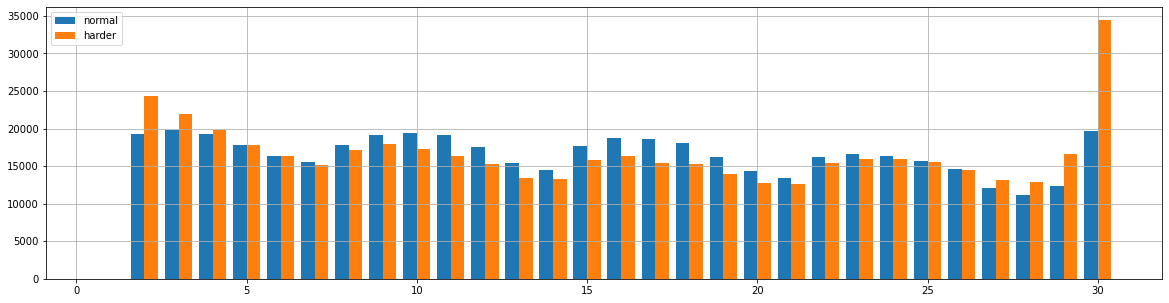

In [24]:
valid1 = pd.read_csv("../data/validation_seed2.csv")
valid2 = pd.read_csv("../data/validation_seed2_harder.csv")

plt.figure(figsize=(20,5))
plt.hist([valid1.inventory_days, valid2.inventory_days], bins=np.arange(0,31), rwidth=0.8, align="right", label=["normal","harder"])
plt.grid()
plt.legend(loc="best")
plt.show()

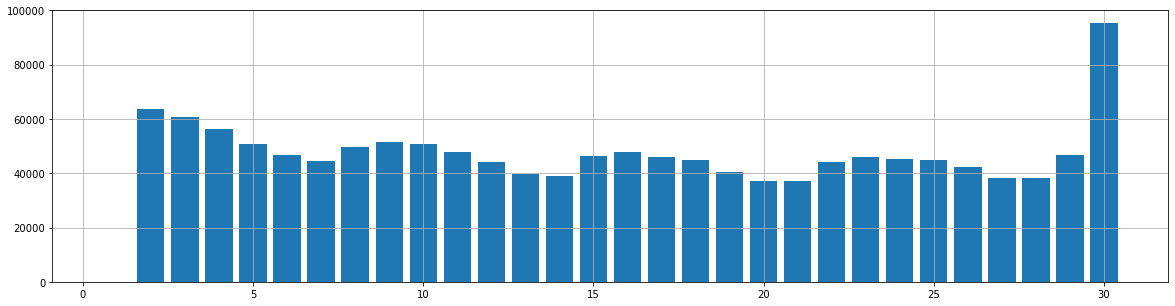

In [25]:
plt.figure(figsize=(20,5))
plt.hist(valid_m3.inventory_days, bins=np.arange(0,31), 
         rwidth=0.8, align="right", density=False)
plt.grid()
plt.show()

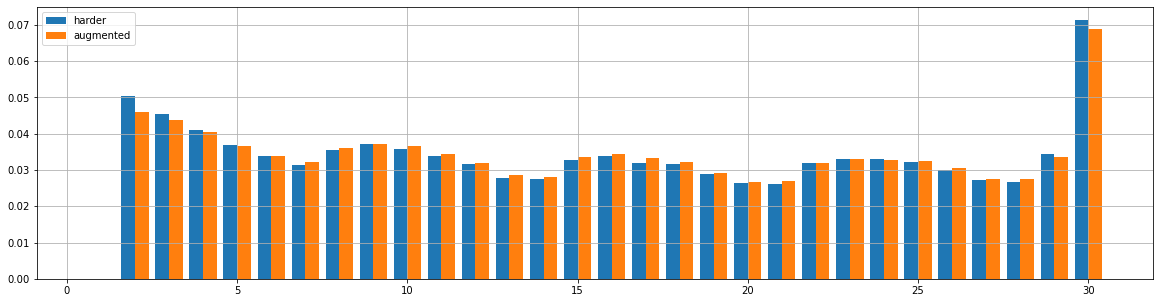

In [26]:
plt.figure(figsize=(20,5))
plt.hist([valid2.inventory_days,valid_m3.inventory_days], bins=np.arange(0,31), 
         rwidth=0.8, align="right", density=True, label=["harder","augmented"])
plt.grid()
plt.legend(loc="best")
plt.show()

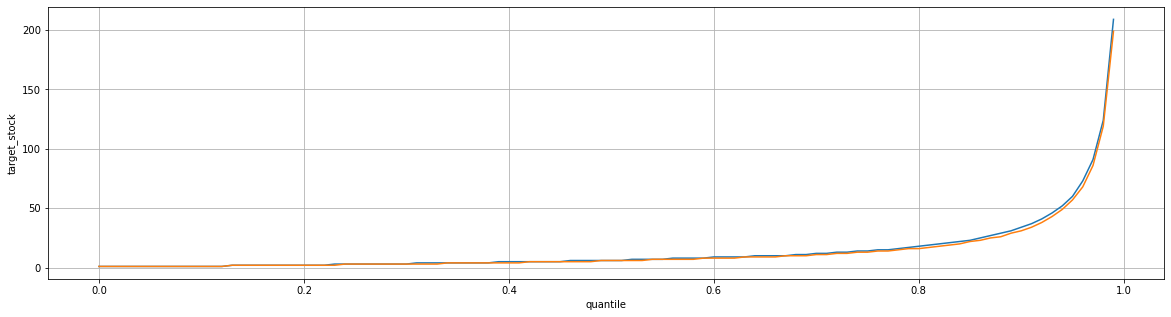

In [27]:
plt.figure(figsize=(20,5))
valid1.target_stock.quantile(np.arange(0,1,0.01)).plot()
valid2.target_stock.quantile(np.arange(0,1,0.01)).plot()
plt.grid()
plt.xlabel("quantile")
plt.ylabel("target_stock")
plt.show()

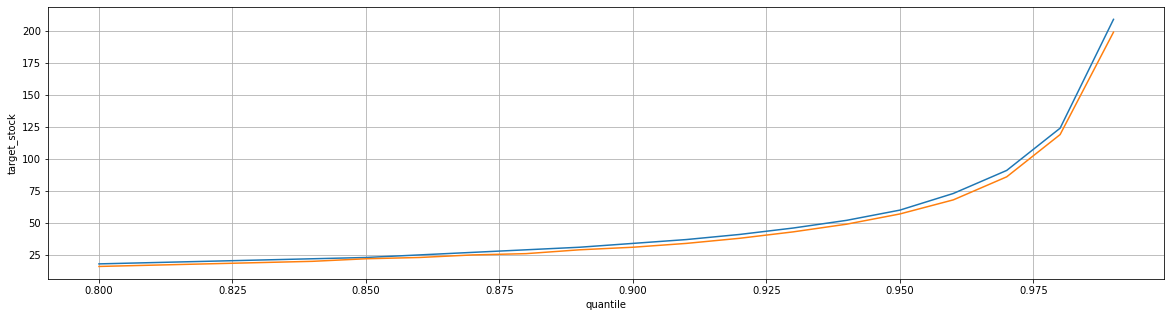

In [28]:
plt.figure(figsize=(20,5))
valid1.target_stock.quantile(np.arange(0.8,1,0.01)).plot()
valid2.target_stock.quantile(np.arange(0.8,1,0.01)).plot()
plt.grid()
plt.xlabel("quantile")
plt.ylabel("target_stock")
plt.show()

***